# Dog Breed Classification using AWS Sagemaker
Udacity AWS Machine Learning Engineer Nanodegree <br>
Jean Carlos da Cruz

This Python Notebook implements the Image Classification using AWS SageMaker with a pre-trained model.

The following tasks are performed.
- A pretrained Resnet50 model from pytorch vision library is used in the project (https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)
- Finetune the model with hyperparameter tuning and Network Re-shaping
- Implement Profiling and Debugging with hooks
- Deploy the model and perform inference


In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 19.8 MB/s            
     |████████████████████████████████| 83 kB 200 kB/s             
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-305959699263


## Dataset
For this project I'm using the dataset provided by Udacity that contains Dog images.

In [4]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-03-23 11:47:25--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.163.157
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.163.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  26.5MB/s    in 41s     

2022-03-23 11:48:09 (26.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [5]:
print("Starting to uploading dogImages")

input_path = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix="dogImages")
print(f"Input path ( S3 file path ): {input_path}")

Starting to uploading dogImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-305959699263/dogImages


## Hyperparameter Tuning
- The ResNet model represents the deep Residual Learning Framework to ease the training process.
- A pair of fully connected Neural Networks has been added on top of the pretrained model to perform the classification task with 133 output nodes.
- AdamW from torch.optm is used as an optimizer.
- The Following hyperparamets are used:
    - Learning rate-  0.0001 to 0.1
    - eps -  1e-09 to 1e-08
    - Weight decay -  1e-3 to 1e-1
    - Batch size -  [ 64, 128 ]

The `hpo.py` script is used to perform hyperparameter tuning.

In [6]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [8]:
tuner.fit({"training": input_path }, wait=True)

...................................................................................................................................................................................................................................................................!


In [9]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-03-23 12:21:28 Starting - Preparing the instances for training
2022-03-23 12:21:28 Downloading - Downloading input data
2022-03-23 12:21:28 Training - Training image download completed. Training in progress.
2022-03-23 12:21:28 Uploading - Uploading generated training model
2022-03-23 12:21:28 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '4.107647326808681e-09',
 'lr': '0.0008636884018274005',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2022-03-23-12-09-53-648"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-305959699263/dog-breed-classification-hpo-2022-03-23-12-09-53-648/source/sourcedir.tar.gz"',
 'weight_decay': '0.007413593320182842'}

In [11]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '4.107647326808681e-09', 'lr': '0.0008636884018274005', 'weight_decay': '0.007413593320182842'}


## Model Profiling and Debugging
The hyperparameters obtained above is used to finetune the model

The `train_model.py` script is used to perform model profiling and debugging.

In [12]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [13]:
#Creating and fitting an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #Using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, #Including the profiler hook
    debugger_hook_config=debugger_config, #Including the debugger hook
    rules=rules
)

estimator.fit({'train' : input_path },wait=True)

2022-03-23 12:35:17 Starting - Starting the training job...
2022-03-23 12:35:40 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-03-23 12:36:43 Downloading - Downloading input data............
2022-03-23 12:38:44 Training - Downloading the training image...
2022-03-23 12:39:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-23 12:39:13,063 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-23 12:39:13,089 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-23 12:39:13,097 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-23 12:39:13,513 sagemaker-training-toolkit INFO     Invok

In [14]:
#Fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-03-23-12-35-16-396
Client: <botocore.client.SageMaker object at 0x7f9f15ddc850>
Description: {'TrainingJobName': 'pytorch-training-2022-03-23-12-35-16-396', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:305959699263:training-job/pytorch-training-2022-03-23-12-35-16-396', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"4.107647326808681e-09"', 'lr': '"0.0008636884018274005"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-03-23-12-35-16-396"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/source/sourcedir.tar.gz"', 'weight_decay': '"0.007413593320182842"'}, 'AlgorithmSpecif

In [15]:
#Defining a Trail

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-03-23 12:47:31.325 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-23 12:47:31.357 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/debug-output


[2022-03-23 12:47:54.513 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-23 12:47:55.554 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


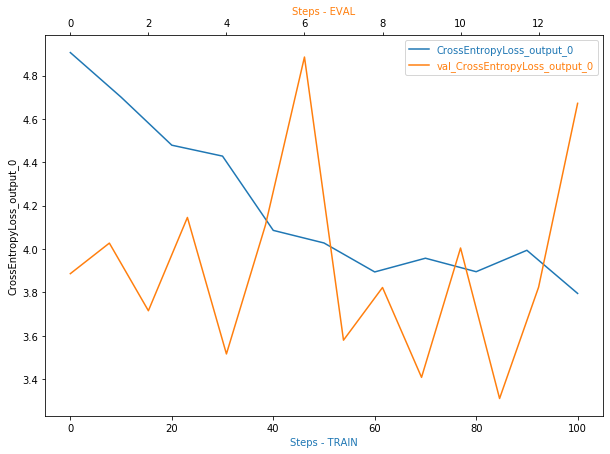

In [16]:
#Plotting a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#Setting a utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#Plotting tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?** <br>
*It is not possible to see any smoth outplut line, actually we can see different highs and lows for the batchs.* <br>

**If not, suppose there was an error. What would that error look like and how would you have fixed it?** <br>
*We could try setting a proper mix of the batches with shuffling. Also, trying out different neural network architecture could help the model learn better.*

In [17]:
#Displaying the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/rule-output


In [18]:
! aws s3 ls {rule_output_path} --recursive

2022-03-23 12:45:26     381585 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-23 12:45:25     230761 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-23 12:45:21        191 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-23 12:45:21      19738 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-23 12:45:22        126 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-23 12:45:21        129 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-03-23 12:45:21       2446 pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-35-16-396/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-2

In [20]:
import os

#Getting the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [24]:
#Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/dog-project/profiler_report.zip'

## Model Deploying

In [30]:
#Deploying your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

------!

In [37]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-305959699263/pytorch-training-2022-03-23-12-56-06-466/model.tar.gz"


#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

---------!

Test image no: 1
Below is the image that we will be testing:


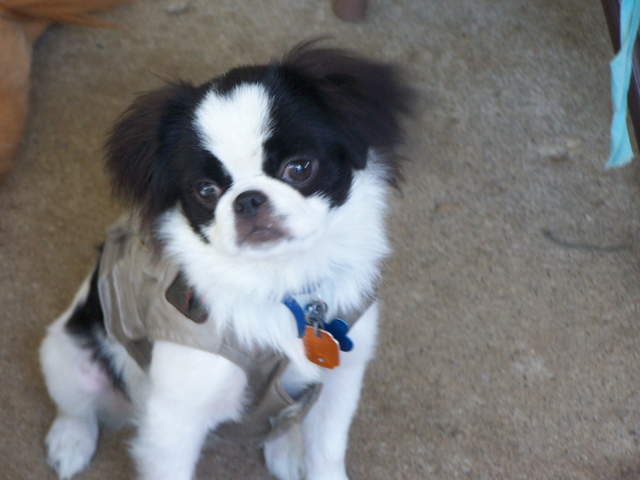

Expected dog breed category no : 91
Response: [[0.0, 0.0, 0.0, 0.0, 0.039222631603479385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5390759706497192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039111487567424774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.227323055267334, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2084835767745972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8731054067611694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.885985851287842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.557633399963379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [91]
Test image no: 2
Below is the image that we will be testing:


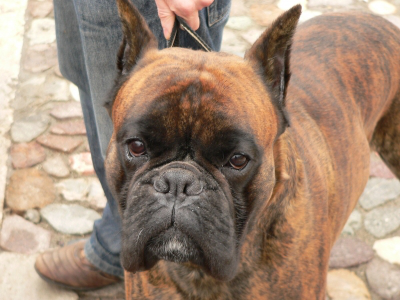

Expected dog breed category no : 34
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.670853853225708, 0.0, 0.0, 0.0, 0.19348585605621338, 0.0, 1.6240959167480469, 0.0, 0.0, 1.7454264163970947, 0.3438812494277954, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3509961664676666, 0.0, 0.0, 0.0, 0.30454757809638977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4038724899291992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5824896693229675, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7622347474098206, 0.0, 0.0, 0.0, 0.0, 0.10089327394962311, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [41]
Test image no: 3
Below is the image that we will be testing:


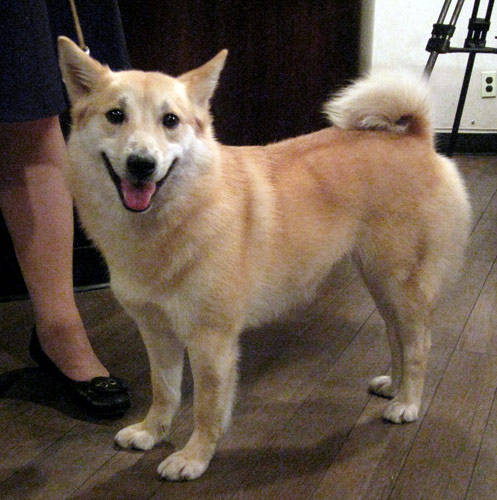

Expected dog breed category no : 108
Response: [[0.0, 0.0, 0.0, 0.0, 0.31939828395843506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5542609691619873, 0.0, 0.0, 0.0, 0.7184728384017944, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9917367100715637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6917479038238525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07865515351295471, 0.0, 1.038286805152893, 0.0, 0.04229969158768654, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [71]


In [43]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ "TestImg_Japanese_Chin.jpg", 'TestImg_Boxer.jpg', 'TestImg_Norwegian_Buhund.jpg' ]
test_images_expected_output = [91, 34, 108]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [44]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2022-03-23-13-12-53-799


In [47]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()